In [1]:
import torch
import torchaudio
from pypinyin import lazy_pinyin
import matplotlib
import matplotlib.pyplot as plt

In [38]:
from model.quartznet import QuartzNet
from model.config import quartznet5x5_config

model = QuartzNet(quartznet5x5_config, feat_in = 80, vocab_size=30)
model(torch.zeros([2,80,581])).shape
# model.encoder[0].net[0][0].stride[0]

torch.Size([2, 30, 291])

In [2]:
from utils.dataset import SpeechOceanDataset

def audio_transform(sample, sample_rate):
    audio = sample['audio']
    text = sample['text']
    mel_transform = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate,\
        n_fft=1024,power=1,hop_length=256,win_length=1024, n_mels=80, \
            f_min=0.0, f_max=8000.0, mel_scale="slaney", norm="slaney")
    def chinese2pinyin(text):
        pinyin = lazy_pinyin(text, strict=True,errors=lambda x: u'')
        pinyin = [i for i in '|'.join(pinyin)]
        return pinyin
    safe_log = lambda x: torch.log(x+2**(-15))
    return {'audio':safe_log(mel_transform(audio)),
            'text': chinese2pinyin(text)}

dataset = SpeechOceanDataset('./data/zhspeechocean/', transform=audio_transform)

('bu|hao|yi|si|xia|zhou|san|ke|yi|ma|zui|jin|tai|mang',
 torch.Size([1, 80, 268]))

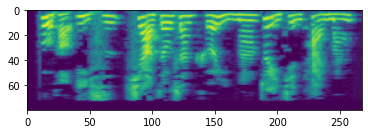

In [4]:
plt.imshow(dataset[0]['audio'][0])
''.join(dataset[0]['text']), dataset[0]['audio'].shape

In [27]:
class LoaderGenerator:
    def __init__(self, 
        labels, k_size=0, 
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        ) -> None:
        self.k_size = k_size
        self.labels = labels
        self.look_up = {s: i for i, s in enumerate(labels)}
        self.device = device

    def label2id(self, str):
        return [self.look_up[i] for i in str]

    def id2label(self, idcs):
        return ''.join([self.labels[i] for i in idcs])

    def batch_filter(self, batch:list):
        # remove all audio with tag if audio length > threshold
        for i in range(len(batch)-1, -1, -1):
            if batch[i]['audio'].shape[-1] > self.threshold/256: # 256 is the hop_length of fft
                del batch[i]
        return batch

    def collate_wrapper(self, batch):
        batch = self.batch_filter(batch)
        bs = len(batch)
        # 1. shift each audio right with several blocks < first kernel in the model
        rand_shift = torch.randint(self.k_size, (bs,))
        audio_list = [
            torch.cat(
            (torch.log(torch.full((1, 80, rand_shift[i]), 2**(-15))), batch[i]['audio']), -1)
            for i in range(bs)]
        # 2. get audio length and pad them to the same length
        audio_length = torch.tensor([audio.shape[-1] for audio in audio_list])
        max_audio_length = torch.max(audio_length)
        audio_list = torch.cat([
            torch.cat(
            (audio, torch.log(torch.full((1, 80, max_audio_length-audio.shape[-1]), 2**(-15)))), -1)
            for audio in audio_list], 0)
        # 3. do the same padding process on text
        target_list = [self.label2id(item['text']) for item in batch]
        target_length = torch.tensor([len(l) for l in target_list])
        max_target_length = torch.max(target_length)
        target_list = torch.cat([
            torch.cat(
            (torch.tensor(l), torch.zeros([max_target_length-len(l)], dtype=torch.int)), -1).unsqueeze(0) 
            for l in target_list], 0)
        # 4. return data on device
        device = self.device
        return {'audio': audio_list.to(device), 'target': target_list.to(device), 'audio_len': audio_length.to(device), 'target_len': target_length.to(device)}

    def dataloader(self, audioDataset, batch_size, shuffle=True):
        # k_size is the kernel size for the encoder, for data augmentation
        self.threshold = audioDataset.dataset.threshold
        return DataLoader(audioDataset, batch_size,
                            shuffle, num_workers=0, collate_fn=self.collate_wrapper)

from torch.utils.data import DataLoader, Dataset, random_split
from utils.helper import get_labels
loaderGenerator = LoaderGenerator(get_labels(), k_size=33)
train_set, test_set = dataset.split()
train_loader = loaderGenerator.dataloader(train_set, batch_size=8)
print('train_set:', len(train_set), 'test_set:',len(test_set))
steps = 10
for i_batch, sample_batched in enumerate(train_loader):
    print(sample_batched['audio'].shape, sample_batched['target'].shape)
    # plt.imshow(sample_batched['audio'][0])
    # print(loaderGenerator.id2label(sample_batched['target'][0].tolist()))
    # print(sample_batched['audio_len'][0])
    # print(sample_batched['target_len'][0])
    # break
    if steps < 0:
        break
    steps -= 1


train_set: 2285 test_set: 115
torch.Size([8, 80, 238]) torch.Size([8, 73])
torch.Size([8, 80, 294]) torch.Size([8, 71])
torch.Size([8, 80, 255]) torch.Size([8, 78])
torch.Size([8, 80, 245]) torch.Size([8, 52])
torch.Size([8, 80, 372]) torch.Size([8, 71])
torch.Size([8, 80, 303]) torch.Size([8, 76])
torch.Size([8, 80, 280]) torch.Size([8, 62])
torch.Size([8, 80, 204]) torch.Size([8, 55])
torch.Size([8, 80, 280]) torch.Size([8, 74])
torch.Size([7, 80, 332]) torch.Size([7, 83])
torch.Size([8, 80, 405]) torch.Size([8, 62])
torch.Size([8, 80, 279]) torch.Size([8, 67])


In [22]:
import os
from numpy import dtype
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchaudio

class AiShellDataset(Dataset):

    def __init__(self, data_path, sample_rate=16000, transform=None):
        transcript_file = data_path+'transcript/aishell_transcript_v0.8.txt'
        self.transcript = self.gen_transcript(transcript_file)
        self.wav_files = self.get_all_wav_files(data_path, self.transcript)
        self.dataset_file_num = len(self.wav_files)
        self.data_path = data_path
        self.transform = transform
        self.sample_rate = sample_rate
        self.threshold = 120000 # to avoid GPU memory used out
        self.batch_size = 80 # to avoid GPU memory used out
        self.split_ratio = [1000, 1]

    def __len__(self):
        return self.dataset_file_num

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        if idx >= self.dataset_file_num:
            return {'audio': None, 'text': None}
        audio_name = self.wav_files[idx]
        waveform, sample_rate = torchaudio.load(audio_name)
        waveform = waveform
        if sample_rate != self.sample_rate:
            waveform = torchaudio.functional.resample(waveform, sample_rate, self.sample_rate)
        dict_id = audio_name.rsplit('/',1)[-1].split('.')[0]
        audio_content = self.transcript[dict_id]
        sample = {'audio': waveform, 'text': audio_content}
        if self.transform:
            sample = self.transform(sample)
        return sample

    def parse_line(self, line):
        id, text = line.split(' ', 1)
        text = ''.join(text.split(' '))
        return id, text

    def gen_transcript(self, transcript_file):
        transcript = {}
        with open(transcript_file, 'r') as f:
            content = f.read()
            lines = content.split('\n')[:-1]
            for line in lines:
                id, text = self.parse_line(line)
                transcript[id] = text
        return transcript

    def get_all_wav_files(self, path, transcript):
        folders = []
        train = os.listdir(path+'wav/train/')
        folders += [path+'wav/train/'+i for i in train]
        dev = os.listdir(path+'wav/dev/')
        folders += [path+'wav/dev/'+i for i in dev]
        test = os.listdir(path+'wav/test/')
        folders += [path+'wav/test/'+i for i in test]
        files = []
        for folder in folders:
            files += [folder+'/'+i for i in os.listdir(folder) if i[:-4] in transcript]
        return files
    
    def split(self, split_ratio=None, seed=42):
        audio_dataset = self
        size = len(audio_dataset)
        my_split_ratio = self.split_ratio if split_ratio is None else split_ratio
        lengths = [(i*size)//sum(my_split_ratio) for i in my_split_ratio]
        lengths[-1] = size - sum(lengths[:-1])
        split_dataset = random_split(audio_dataset, lengths, generator=torch.Generator().manual_seed(seed))
        return split_dataset

In [11]:
if __name__ == '__main__':
    # dataset = AudioDataset('./data/ST-CMDS-20170001_1-OS/')
    dataset = AiShellDataset('./data/data_aishell/')
    batch_size = 8
    train_set, test_set = dataset.split([1000, 5])
    k_size = 5 # kernel size for audio encoder
    from pypinyin import lazy_pinyin
    def chinese2pinyin(text):
        pinyin = lazy_pinyin(text, strict=True,errors=lambda x: u'')
        pinyin = [i for i in '|'.join(pinyin)]
        return pinyin
    from utils.helper import get_labels
    from utils.dataset import LoaderGenerator
    labels = get_labels()
    loaderGenerator = LoaderGenerator(labels, chinese2pinyin, k_size)
    train_loader = loaderGenerator.dataloader(train_set, batch_size)
    test_loader = loaderGenerator.dataloader(test_set, batch_size) # without backprop, can use larger batch
    print('train_set:', len(train_set), 'test_set:',len(test_set))
    steps = 10
    for i_batch, sample_batched in enumerate(test_loader):
        print(sample_batched['audio'].shape, sample_batched['target'].shape)
        # for i in sample_batched['audio']:
        #     print(i.shape)
        if steps < 0:
            break
        steps -= 1

train_set: 140895 test_set: 705
torch.Size([8, 94301]) torch.Size([8, 82])
torch.Size([7, 90778]) torch.Size([7, 75])
torch.Size([8, 95557]) torch.Size([8, 90])
torch.Size([8, 96123]) torch.Size([8, 89])
torch.Size([8, 102204]) torch.Size([8, 95])
torch.Size([6, 97673]) torch.Size([6, 93])
torch.Size([8, 88088]) torch.Size([8, 76])
torch.Size([8, 95365]) torch.Size([8, 75])
torch.Size([7, 77399]) torch.Size([7, 67])
torch.Size([8, 102859]) torch.Size([8, 73])
torch.Size([8, 93783]) torch.Size([8, 78])
torch.Size([8, 103609]) torch.Size([8, 82])


In [12]:
dataset = AiShellDataset('./data/data_aishell/')
lens = [dataset[i]['audio'].shape[-1] for i in range(500)]

In [13]:
lens2 = [dataset[i+500]['audio'].shape[-1] for i in range(1000)]

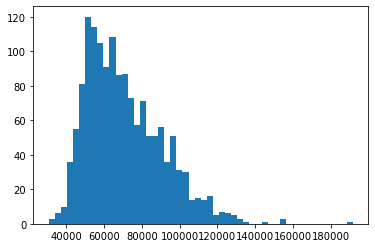

In [14]:
import matplotlib.pyplot as plt
plt.hist(lens+lens2, bins = 50)
plt.show()

In [15]:
import json

In [34]:
import os
from numpy import dtype
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchaudio

class PrimeWordsDataset(Dataset):

    def __init__(self, data_path, sample_rate=16000, transform=None):
        with open(data_path+'set1_transcript.json') as f:
            json_data = json.load(f)
        self.json_data = json_data
        # self.wav_files = self.get_all_wav_files(data_path, self.transcript)
        self.dataset_file_num = len(self.json_data)
        self.data_path = data_path
        self.transform = transform
        self.sample_rate = sample_rate
        self.threshold = 220000 # to avoid GPU memory used out
        self.batch_size = 40 # to avoid GPU memory used out
        self.split_ratio = [1000, 2]

    def __len__(self):
        return self.dataset_file_num

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        if idx >= self.dataset_file_num:
            return {'audio': None, 'text': None}
        audio_file, audio_content = self.parse_line(self.json_data[idx])
        waveform, sample_rate = torchaudio.load(self.get_wav(audio_file))
        waveform = waveform
        if sample_rate != self.sample_rate:
            waveform = torchaudio.functional.resample(waveform, sample_rate, self.sample_rate)
        sample = {'audio': waveform, 'text': audio_content}
        if self.transform:
            sample = self.transform(sample)
        return sample

    def parse_line(self, line):
        return line['file'], line['text']

    def get_wav(self, file_name):
        path = self.data_path+'audio_files/'+file_name[0]+'/'+file_name[:2]+'/'+file_name
        return path

    def split(self, split_ratio=None, seed=42):
        audio_dataset = self
        size = len(audio_dataset)
        my_split_ratio = self.split_ratio if split_ratio is None else split_ratio
        lengths = [(i*size)//sum(my_split_ratio) for i in my_split_ratio]
        lengths[-1] = size - sum(lengths[:-1])
        split_dataset = random_split(audio_dataset, lengths, generator=torch.Generator().manual_seed(seed))
        return split_dataset

In [35]:
if __name__ == '__main__':
    dataset = PrimeWordsDataset('./data/primewords_md_2018_set1/')
    batch_size = 8
    train_set, test_set = dataset.split([1000, 5])
    k_size = 5 # kernel size for audio encoder
    from pypinyin import lazy_pinyin
    def chinese2pinyin(text):
        pinyin = lazy_pinyin(text, strict=True,errors=lambda x: u'')
        pinyin = [i for i in '|'.join(pinyin)]
        return pinyin
    from utils.helper import get_labels
    from utils.dataset import LoaderGenerator
    labels = get_labels()
    loaderGenerator = LoaderGenerator(labels, chinese2pinyin, k_size)
    train_loader = loaderGenerator.dataloader(train_set, batch_size)
    test_loader = loaderGenerator.dataloader(test_set, batch_size) # without backprop, can use larger batch
    print('train_set:', len(train_set), 'test_set:',len(test_set))
    steps = 10
    for i_batch, sample_batched in enumerate(test_loader):
        print(sample_batched['audio'].shape, sample_batched['target'].shape)
        # for i in sample_batched['audio']:
        #     print(i.shape)
        if steps < 0:
            break
        steps -= 1

train_set: 50648 test_set: 254
torch.Size([8, 176636]) torch.Size([8, 102])
torch.Size([8, 145909]) torch.Size([8, 94])
torch.Size([8, 139198]) torch.Size([8, 92])
torch.Size([8, 140152]) torch.Size([8, 94])
torch.Size([8, 151359]) torch.Size([8, 98])
torch.Size([8, 130548]) torch.Size([8, 97])
torch.Size([8, 182392]) torch.Size([8, 108])
torch.Size([7, 152315]) torch.Size([7, 101])
torch.Size([8, 176638]) torch.Size([8, 92])
torch.Size([7, 161280]) torch.Size([7, 88])
torch.Size([8, 168951]) torch.Size([8, 112])
torch.Size([8, 169595]) torch.Size([8, 106])


In [27]:
dataset = PrimeWordsDataset('./data/primewords_md_2018_set1/')
lens = [dataset[i]['audio'].shape[-1] for i in range(500)]

In [51]:
i=15
torchaudio.save('./audio-temp.wav', dataset[i]['audio'], 16000)
dataset[i]

{'audio': tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0003, 0.0002, 0.0001]]),
 'text': '两碑尺寸相同 规格一致 均高六点八七米 分别由螭龙碑首'}

In [28]:
lens2 = [dataset[i+500]['audio'].shape[-1] for i in range(1000)]

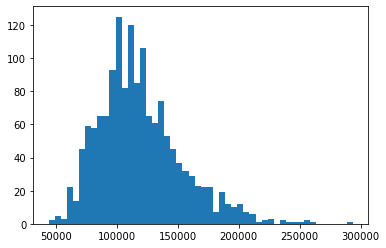

In [29]:
import matplotlib.pyplot as plt
plt.hist(lens+lens2, bins = 50)
plt.show()

In [65]:
import pandas as pd
data_path = './data/zhspeechocean/'


class SpeechOceanDataset(Dataset):
    def __init__(self, data_path, sample_rate=16000, transform=None):
        meta_data = data_path + 'metadata.csv'
        self.meta_data = pd.read_csv(meta_data, sep='\t')
        self.dataset_file_num = len(self.meta_data)
        self.data_path = data_path
        self.transform = transform
        self.sample_rate = sample_rate
        self.threshold = 90000 # to avoid GPU memory used out
        self.batch_size = 128 # to avoid GPU memory used out
        self.split_ratio = [100, 5]

    def __len__(self):
        return self.dataset_file_num

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        if idx >= self.dataset_file_num:
            return {'audio': None, 'text': None}
        audio_name = os.path.join(self.data_path,
                                  self.meta_data.iloc[idx, 0])
        waveform, sample_rate = torchaudio.load(audio_name)
        audio_content = self.meta_data.iloc[idx, 1]
        if sample_rate != self.sample_rate:
            waveform = torchaudio.functional.resample(waveform, sample_rate, self.sample_rate)
        sample = {'audio': waveform, 'text': audio_content}
        if self.transform:
            sample = self.transform(sample)
        return sample

    def split(self, split_ratio=None, seed=42):
        audio_dataset = self
        size = len(audio_dataset)
        my_split_ratio = self.split_ratio if split_ratio is None else split_ratio
        lengths = [(i*size)//sum(my_split_ratio) for i in my_split_ratio]
        lengths[-1] = size - sum(lengths[:-1])
        split_dataset = random_split(audio_dataset, lengths, generator=torch.Generator().manual_seed(seed))
        return split_dataset

In [66]:
if __name__ == '__main__':
    dataset = SpeechOceanDataset('./data/zhspeechocean/')
    batch_size = 8
    train_set, test_set = dataset.split([100, 5])
    k_size = 5 # kernel size for audio encoder
    from pypinyin import lazy_pinyin
    def chinese2pinyin(text):
        pinyin = lazy_pinyin(text, strict=True,errors=lambda x: u'')
        pinyin = [i for i in '|'.join(pinyin)]
        return pinyin
    from utils.helper import get_labels
    from utils.dataset import LoaderGenerator
    labels = get_labels()
    loaderGenerator = LoaderGenerator(labels, chinese2pinyin, k_size)
    train_loader = loaderGenerator.dataloader(train_set, batch_size)
    test_loader = loaderGenerator.dataloader(test_set, batch_size) # without backprop, can use larger batch
    print('train_set:', len(train_set), 'test_set:',len(test_set))
    steps = 10
    for i_batch, sample_batched in enumerate(test_loader):
        print(sample_batched['audio'].shape, sample_batched['target'].shape)
        # for i in sample_batched['audio']:
        #     print(i.shape)
        if steps < 0:
            break
        steps -= 1

train_set: 2285 test_set: 115
torch.Size([7, 76030]) torch.Size([7, 66])
torch.Size([8, 85818]) torch.Size([8, 66])
torch.Size([8, 80063]) torch.Size([8, 89])
torch.Size([7, 56436]) torch.Size([7, 54])
torch.Size([8, 76025]) torch.Size([8, 67])
torch.Size([8, 79484]) torch.Size([8, 68])
torch.Size([8, 65661]) torch.Size([8, 76])
torch.Size([8, 67958]) torch.Size([8, 75])
torch.Size([8, 59323]) torch.Size([8, 70])
torch.Size([8, 86392]) torch.Size([8, 66])
torch.Size([8, 55872]) torch.Size([8, 50])
torch.Size([8, 52413]) torch.Size([8, 47])


In [70]:
dataset = SpeechOceanDataset('./data/zhspeechocean/')
lens = [dataset[i]['audio'].shape[-1] for i in range(2000)]

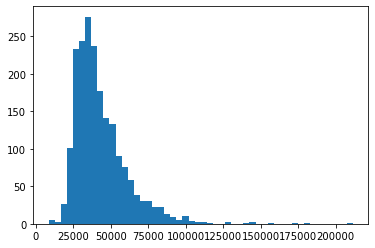

In [71]:
import matplotlib.pyplot as plt
plt.hist(lens, bins = 50)
plt.show()

In [72]:
i=15
torchaudio.save('./audio-temp.wav', dataset[i]['audio'], 16000)
dataset[i]

{'audio': tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -2.2709e-05,
          -7.3612e-05, -1.0139e-04]]),
 'text': '你这个周末有时间吗？你陪我去看看手机行吗？'}

In [74]:
def chinese2pinyin(text):
    pinyin = lazy_pinyin(text, strict=True,errors=lambda x: u'')
    pinyin = [i for i in '|'.join(pinyin)]
    return pinyin
''.join(chinese2pinyin('你这个周末有时间吗？你陪我去看看手机行吗？'))

'ni|zhe|ge|zhou|mo|you|shi|jian|ma|ni|pei|wo|qu|kan|kan|shou|ji|xing|ma'

In [75]:
class CvCorpus8Dataset(Dataset):

    def __init__(self, data_path, sample_rate=16000, transform=None):
        df1 = pd.read_csv(data_path+'validated.tsv',sep='\t')[['path', 'sentence']]
        # df2 = pd.read_csv(data_path+'invalidated.tsv',sep='\t')[['path', 'sentence']]
        # df3 = pd.read_csv(data_path+'other.tsv',sep='\t')[['path', 'sentence']]
        # df = pd.concat([df1, df2, df3])
        df = df1
        audio_path = df['path'].to_list()
        sentence_text = df['sentence'].to_list()
        assert len(audio_path) == len(sentence_text)
        self.audio_path = audio_path
        self.sentence_text = sentence_text
        self.size = len(audio_path)
        self.data_path = data_path
        self.transform = transform
        self.sample_rate = sample_rate
        self.threshold = 170000 # to avoid GPU memory used out
        self.batch_size = 64 # to avoid GPU memory used out
        self.split_ratio = [100, 1]

    def __len__(self):
        return len(self.audio_path)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        audio_name = self.get_audio(idx)
        waveform, sample_rate = torchaudio.load(audio_name)
        waveform = waveform
        if sample_rate != self.sample_rate:
            waveform = torchaudio.functional.resample(waveform, sample_rate, self.sample_rate)
        audio_content = self.get_text(idx)
        sample = {'audio': waveform, 'text': audio_content}
        if self.transform:
            sample = self.transform(sample)
        return sample

    def get_audio(self, x): 
        return self.data_path+'clips/'+self.audio_path[x] if x < len(self) else None
        
    def get_text(self, x): 
        return self.sentence_text[x] if x < len(self) else None
    
    def split(self, split_ratio=None, seed=42):
        audio_dataset = self
        size = len(audio_dataset)
        my_split_ratio = self.split_ratio if split_ratio is None else split_ratio
        lengths = [(i*size)//sum(my_split_ratio) for i in my_split_ratio]
        lengths[-1] = size - sum(lengths[:-1])
        split_dataset = random_split(audio_dataset, lengths, generator=torch.Generator().manual_seed(seed))
        return split_dataset

In [76]:
if __name__ == '__main__':
    dataset = CvCorpus8Dataset('./data/cv-corpus-8.0-2022-01-19/zh-CN/')
    batch_size = 8
    train_set, test_set = dataset.split([100, 5])
    k_size = 5 # kernel size for audio encoder
    from pypinyin import lazy_pinyin
    def chinese2pinyin(text):
        pinyin = lazy_pinyin(text, strict=True,errors=lambda x: u'')
        pinyin = [i for i in '|'.join(pinyin)]
        return pinyin
    from utils.helper import get_labels
    from utils.dataset import LoaderGenerator
    labels = get_labels()
    loaderGenerator = LoaderGenerator(labels, chinese2pinyin, k_size)
    train_loader = loaderGenerator.dataloader(train_set, batch_size)
    test_loader = loaderGenerator.dataloader(test_set, batch_size) # without backprop, can use larger batch
    print('train_set:', len(train_set), 'test_set:',len(test_set))
    steps = 10
    for i_batch, sample_batched in enumerate(test_loader):
        print(sample_batched['audio'].shape, sample_batched['target'].shape)
        # for i in sample_batched['audio']:
        #     print(i.shape)
        if steps < 0:
            break
        steps -= 1

train_set: 44517 test_set: 2226
torch.Size([8, 124029]) torch.Size([8, 71])
torch.Size([8, 155901]) torch.Size([8, 126])
torch.Size([8, 148988]) torch.Size([8, 128])
torch.Size([8, 122877]) torch.Size([8, 110])
torch.Size([8, 142838]) torch.Size([8, 107])
torch.Size([8, 153984]) torch.Size([8, 131])
torch.Size([8, 142079]) torch.Size([8, 121])
torch.Size([8, 155904]) torch.Size([8, 90])
torch.Size([8, 131712]) torch.Size([8, 93])
torch.Size([8, 101753]) torch.Size([8, 94])
torch.Size([8, 97920]) torch.Size([8, 89])
torch.Size([8, 165877]) torch.Size([8, 140])


In [77]:
dataset = CvCorpus8Dataset('./data/cv-corpus-8.0-2022-01-19/zh-CN/')

In [81]:
i=18
torchaudio.save('./audio-temp.wav', dataset[i]['audio'], 16000)
dataset[i]

{'audio': tensor([[ 0.0000,  0.0000,  0.0000,  ..., -0.0020, -0.0029, -0.0024]]),
 'text': '台湾北部地区家庭多以在农历年前时段包润饼则是在清明期间。'}